In [1]:
import numpy as np, scipy, pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates as md
import seaborn as sns, sklearn
from datetime import datetime, timedelta, date, time
import pickle 

In [2]:
#!pip install tensorflow
#tf.__version__

# load and understand the data 

In [2]:
import boto3 
import json

# read file
with open('/opt/ml/metadata/resource-metadata.json', 'r') as file:
    data=file.read()
# parse file
obj = json.loads(data)
notebookName = str(obj['ResourceName']).lower()
data_key = 'dataslices/1684747985-dataslice.csv'
data_location = 's3://{}/{}'.format(notebookName, data_key)

In [3]:
# load the data and set the timeline from 2022, convert string format to datetime for convenient manipulation, 
# then convert YYMMDD to YYMMDDHHMMSS, takes up to 3 minutes for the conversion
def generate_dft(data_location):
    dft=pd.read_csv(data_location)
    dft=dft[dft['settlement_date'] >= '2022-01-01']
    dft=dft.reset_index()
    dft=dft.drop(['index'], axis=1) 
    dft['settlement_date']=pd.to_datetime(dft['settlement_date']) 
    dft['settlement_date'] = [dft['settlement_date'][i] + timedelta(hours=0.5)*(dft['settlement_period'][i]-1) for i in range(len(dft))]
    return dft

In [4]:
dft = generate_dft(data_location)

In [5]:
dft.head()

,post_code_area,settlement_date,settlement_period,num_mpans,avg_vol_per_mpan
0,AB,2022-01-01 00:00:00,1,200,0.3
1,AB,2022-01-01 00:30:00,2,200,0.3
2,AB,2022-01-01 01:00:00,3,200,0.3
3,AB,2022-01-01 01:30:00,4,200,0.3
4,AB,2022-01-01 02:00:00,5,200,0.4


In [6]:
# check datetypes of the columns

print(type(dft.loc[0,'post_code_area']), type(dft.loc[0,'settlement_date']), type(dft.loc[0,'settlement_period']), type(dft.loc[0,'num_mpans']), type(dft.loc[0,'avg_vol_per_mpan']))

<class 'str'> <class 'pandas._libs.tslibs.timestamps.Timestamp'> <class 'numpy.int64'> <class 'numpy.int64'> <class 'numpy.float64'>


In [7]:
# the HH dataset has covered 120 different postal code areas in the UK

len(dft['post_code_area'].unique())

120

In [12]:
dft.head()

,post_code_area,settlement_date,settlement_period,num_mpans,avg_vol_per_mpan
0,AB,2022-01-01 00:00:00,1,200,0.3
1,AB,2022-01-01 00:30:00,2,200,0.3
2,AB,2022-01-01 01:00:00,3,200,0.3
3,AB,2022-01-01 01:30:00,4,200,0.3
4,AB,2022-01-01 02:00:00,5,200,0.4


# brief data cleaning 

In [13]:
# some results are clearly outliers and should be removed 
dft[dft['avg_vol_per_mpan']>200]

,post_code_area,settlement_date,settlement_period,num_mpans,avg_vol_per_mpan
1071288,HS,2022-03-17 04:00:00,9,6,214.5
1071289,HS,2022-03-17 04:30:00,10,6,227.9
1071290,HS,2022-03-17 05:00:00,11,6,227.4
1071291,HS,2022-03-17 05:30:00,12,6,227.0
1071292,HS,2022-03-17 06:00:00,13,6,231.1
...,...,...,...,...,...
1074061,HS,2022-05-13 23:30:00,48,6,233.8
1074062,HS,2022-05-14 00:00:00,1,6,233.8
1074063,HS,2022-05-14 00:30:00,2,6,233.8
1074161,HS,2022-05-16 01:30:00,4,6,219.0


In [11]:
# run this function to remove major outliers

def brief_cleansing(dft):
    dft=dft.loc[dft['post_code_area'] != 'HS']
    dft.loc[dft['avg_vol_per_mpan']<0, 'avg_vol_per_mpan']=0
    #dft.loc[(dft['settlement_date'] > pd.Timestamp('2021-07-01')) & (dft['settlement_date'] < pd.Timestamp('2021-10-01')) & (dft['avg_vol_per_mpan']>50), 'avg_vol_per_mpan']=50
    dft.loc[(dft['settlement_date'] > pd.Timestamp('2022-09-01')) & (dft['settlement_date'] < pd.Timestamp('2023-03-01')) & (dft['avg_vol_per_mpan']>5), 'avg_vol_per_mpan']=2
    return dft

In [12]:
dft = brief_cleansing(dft)

In [13]:
with open('refined dataset.pickle', 'wb') as f:
            pickle.dump(dft, f)

In [14]:
with open('refined dataset.pickle', 'rb') as f:
    dft=pickle.load(f)

# seasonality and trend

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decomposition_HH(dft):
    dft_hh = dft.drop(['settlement_period', 'num_mpans'], axis=1)
    dft_hh = dft_hh.groupby([dft_hh['settlement_date']]).mean()
    dif = (date(2023,5,14)-date(2022,1,1)).days
    deco = seasonal_decompose(dft_hh['avg_vol_per_mpan'], model='additive', period=dif)
    fig, ax = plt.subplots(3, 1, figsize=(12,9), sharex=True)
    plt.subplots_adjust(hspace=0)
    plt.xlabel('settlement_date')
    deco.trend.plot(ax=ax[0])
    deco.seasonal.plot(ax=ax[1])
    deco.resid.plot(ax=ax[2])
    ax[0].set_ylabel('global trend')
    ax[1].set_ylabel('seasonal')
    ax[2].set_ylabel('residual')
    return plt.show()

/tmp/ipykernel_20189/81553618.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dft_hh = dft_hh.groupby([dft_hh['settlement_date']]).mean()


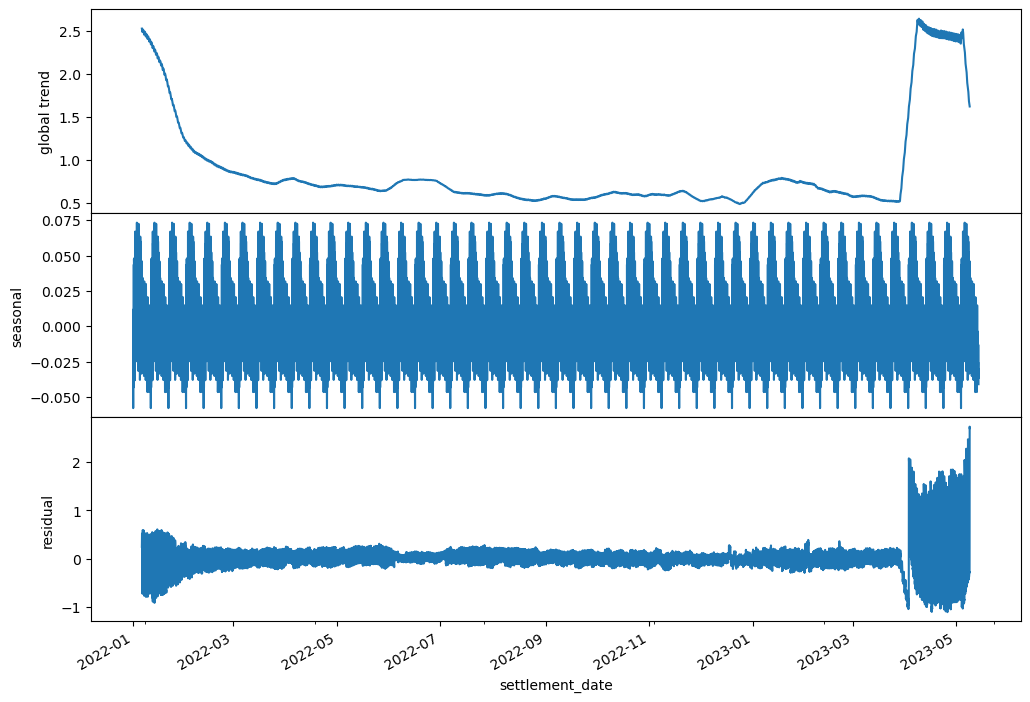

In [41]:
"""the larger the flunctuation in the seasonality, the larger the difference between the day to night consumption during that time period of the year"""
decomposition_HH(dft)

# plot variations

In [15]:
def dft_to_list(dft):
    pc = dft['post_code_area'].unique()
    #dft_dict=dict(zip(pc, [dft[dft['post_code_area']==pc[c]] for c in range(len(pc))]))
    dft_list=[]
    for c in range(len(pc)):
        dft_list.append(dft[dft['post_code_area']==pc[c]])
    return dft_list, pc

In [16]:
dft_list, pc = dft_to_list(dft)

In [17]:
def plot_all_pc(dft_list, pc):
    plt.figure(figsize=(12, 6))
    #plt.xlim(pd.Timestamp('2021-01-01 00:00:00'), pd.Timestamp('2023-01-01 00:00:00'))
    for c in range(len(dft_list)):
        plt.plot(dft_list[c]['settlement_date'], dft_list[c]['avg_vol_per_mpan'], label='{}'.format(pc[c]), linewidth='0.2')
    #plt.legend()
    plt.grid()
    plt.xlim(pd.Timestamp('2022-01-01 00:00:00'), pd.Timestamp('2023-04-01 00:00:00'))
    plt.xlabel('Timeline with HH resolution')
    plt.ylabel('Average consumption per MPAN')
    plt.title('Average volume consumption per MPAN for each post code area | all in one plot')
    return plt.show()

def subplot_all_pc(dft_list, pc):
    plt.figure(figsize=(12, 120))
    fig, ax = plt.subplots(120, 1, figsize=(12, 120), sharex=True)
    plt.xlim(pd.Timestamp('2022-01-01 00:00:00'), pd.Timestamp('2023-04-01 00:00:00'))
    plt.subplots_adjust(hspace=0)
    for c in range(len(dft_list)):
        ax[c].set_ylim(0, 20)
        ax[c].plot(dft_list[c]['settlement_date'], dft_list[c]['avg_vol_per_mpan'], label='{}'.format(pc[c]))
        ax[c].legend()
        fig.text(0.5, 0.04, 'Timeline with HH resolution', ha='center')
        fig.text(0.09, 0.5, 'Average consumption per mpan', va='center', rotation='vertical')  
    plt.title('Average volume consumption per MPAN for each post code area | separate plots')
    return plt.show()

In [ ]:
#plot_all_pc(dft_list, pc)
#subplot_all_pc(dft_list, pc)

In [18]:
def plot_HH_on_the_day(dft, pc):
    dft_hh_pc = dft.drop(['settlement_date', 'num_mpans'], axis=1)
    dft_hh_pc = dft_hh_pc.groupby(['post_code_area', 'settlement_period']).mean()
    dft_hh_pc = dft_hh_pc.reset_index()
    dft_hh_pc_list=[]
    for c in dft_hh_pc['post_code_area'].unique():
        dft_hh_pc_list.append(dft_hh_pc[dft_hh_pc['post_code_area']==c])
    plt.figure(figsize=(12, 6))
    #plt.xlim(1, 50)
    #xaxis = ["{02d}:{02d}".format((some_dt+timedelta(hours=0.5)*i).hour, (some_dt+timedelta(hours=0.5)*i).minute) for i in np.arange(48)]
    for c in range(len(dft_hh_pc_list)):
        plt.plot(dft_hh_pc_list[c]['settlement_period'], dft_hh_pc_list[c]['avg_vol_per_mpan'], label='{}'.format(pc[c]), linewidth='0.5')
    #plt.legend()
    plt.xlabel('HH time slot in a day')
    #some_dt = pd.to_datetime('00:00')
    plt.ylabel('Average consumption per mpan per HH time slot')
    plt.title('Average consumption per mpan per HH time slot from 00:00 to 23:59 of an average day for each post code area')
    return plt.show()

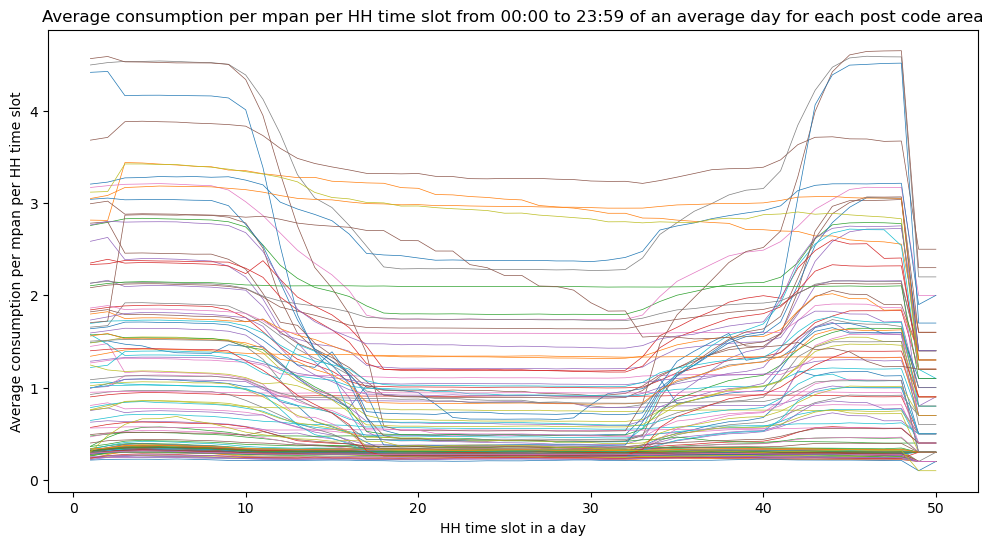

In [19]:
plot_HH_on_the_day(dft, pc)

In [ ]:
#dft_daymax = dft.drop(['settlement_period'], axis=1)
#dft_daymax = dft_daymax.groupby([dft_daymax['settlement_date'].dt.to_period('D')]).max('avg_vol_per_mpan')
#dft_daymin = dft.drop(['settlement_period'], axis=1)
#dft_daymin = dft_daymin.groupby([dft_daymin['settlement_date'].dt.to_period('D')]).min('avg_vol_per_mpan')

In [20]:
def plot_t_res(dft):
    dft_m = dft.drop(['settlement_period', 'num_mpans'], axis=1)
    dft_m = dft_m.groupby([dft_m['settlement_date'].dt.to_period('M')]).mean()
    dft_d = dft.drop(['settlement_period', 'num_mpans'], axis=1)
    dft_d = dft_d.groupby([dft_d['settlement_date'].dt.to_period('D')]).mean()
    dft_hh = dft.drop(['settlement_period', 'num_mpans'], axis=1)
    dft_hh = dft_hh.groupby([dft_hh['settlement_date']]).mean()
    plt.figure(figsize=(12, 6))
    plt.plot(dft_hh, color='lightgrey') 
    plt.plot(dft_d) 
    plt.plot(dft_m)
    #plt.plot(dft_daymax)
    #plt.plot(dft_daymin)
    plt.legend(['Half-Hourly (HH)', 'Daily', 'Monthly'])
    plt.xlim(pd.Timestamp('2022-01-01 00:00:00'), pd.Timestamp('2023-04-01 00:00:00'))
    plt.xlabel('Timeline with different resolutions')
    plt.ylabel('Average consumption per mpan')
    plt.title('Average consumption per mpan averaged across all post codes with different timeline resolutions')
    return plt.show()

/tmp/ipykernel_25901/572741322.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dft_m = dft_m.groupby([dft_m['settlement_date'].dt.to_period('M')]).mean()
/tmp/ipykernel_25901/572741322.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dft_d = dft_d.groupby([dft_d['settlement_date'].dt.to_period('D')]).mean()
/tmp/ipykernel_25901/572741322.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dft_hh = dft_hh.groupb

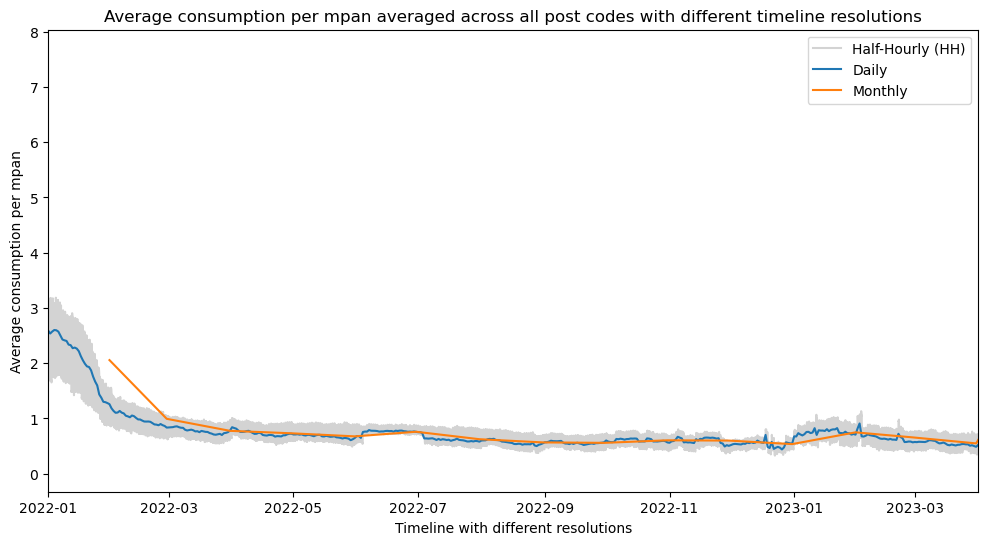

In [21]:
plot_t_res(dft)

In [23]:
print(np.argwhere(pc=='EH'), np.argwhere(pc=='B'), np.argwhere(pc=='M'))
print(np.argwhere(pc=='E'), np.argwhere(pc=='EC'), np.argwhere(pc=='N'), np.argwhere(pc=='NW'), np.argwhere(pc=='SE'), np.argwhere(pc=='SW'), np.argwhere(pc=='W'), np.argwhere(pc=='WC'))

[[32]] [[2]] [[62]]
[[30]] [[31]] [[66]] [[72]] [[86]] [[97]] [[108]] [[110]]


In [24]:
def plot_heatmap(dft):
    dft = dft[dft['settlement_date'] <= pd.Timestamp('2023-04-01')]
    dft_list, pc = dft_to_list(dft)
    dft_hh_pc_EH = dft_list[32].drop(['post_code_area', 'num_mpans'], axis=1)
    dft_hh_pc_EH = dft_hh_pc_EH.groupby([dft_hh_pc_EH['settlement_date'].dt.to_period('D'), 'settlement_period']).mean()
    dft_hh_pc_EH = dft_hh_pc_EH.reset_index()
    dft_hh_pc_EH['settlement_date'] = dft_hh_pc_EH['settlement_date'].astype('str') 
    dft_hh_pc_B = dft_list[2].drop(['post_code_area', 'num_mpans'], axis=1)
    dft_hh_pc_B = dft_hh_pc_B.groupby([dft_hh_pc_B['settlement_date'].dt.to_period('D'), 'settlement_period']).mean()
    dft_hh_pc_B = dft_hh_pc_B.reset_index()
    dft_hh_pc_B['settlement_date'] = dft_hh_pc_B['settlement_date'].astype('str') 
    dft_hh_pc_M = dft_list[62].drop(['post_code_area', 'num_mpans'], axis=1)
    dft_hh_pc_M = dft_hh_pc_M.groupby([dft_hh_pc_M['settlement_date'].dt.to_period('D'), 'settlement_period']).mean()
    dft_hh_pc_M = dft_hh_pc_M.reset_index()  
    dft_hh_pc_M['settlement_date'] = dft_hh_pc_M['settlement_date'].astype('str') 
    dft_hh_london = pd.DataFrame(np.vstack([dft_list[30], dft_list[31], dft_list[66], dft_list[72], dft_list[86], dft_list[97], dft_list[108], dft_list[110]]), columns=dft.columns)
    dft_hh_pc_London = dft_hh_london.drop(['post_code_area', 'num_mpans'], axis=1)
    dft_hh_pc_London = dft_hh_pc_London.groupby([dft_hh_pc_London['settlement_date'].dt.to_period('D'), 'settlement_period']).mean()
    dft_hh_pc_London = dft_hh_pc_London.drop(['settlement_date'], axis=1)
    dft_hh_pc_London = dft_hh_pc_London.reset_index()
    dft_hh_pc_London['settlement_date'] = dft_hh_pc_London['settlement_date'].astype('str') 
    fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
    ax11.set_title('Edinburgh (EH)')
    ax12.set_title('Birmingham (B)')
    ax21.set_title('Manchester (M)')
    ax22.set_title('London (E, EC, N, NW, SE, SW, W, WC)')
    #ytickdates= ['2022-01-01', '2022-04-01', '2022-07-01','2022-10-01', '2023-01-01', '2023-04-01']
    #yticklabels = [d if d in ytickdates else '' for d in dft_hh_pc_EH['settlement_date'].astype(str)]
    fig11 = sns.heatmap(dft_hh_pc_EH.pivot(columns='settlement_period',index='settlement_date',values='avg_vol_per_mpan'), ax=ax11)
    fig12 = sns.heatmap(dft_hh_pc_B.pivot(columns='settlement_period',index='settlement_date',values='avg_vol_per_mpan'), ax=ax12)
    fig21 = sns.heatmap(dft_hh_pc_M.pivot(columns='settlement_period',index='settlement_date',values='avg_vol_per_mpan'), ax=ax21)
    fig22 = sns.heatmap(dft_hh_pc_London.pivot(columns='settlement_period', index='settlement_date', values='avg_vol_per_mpan'), ax=ax22)
    #fig.add_axes([0.94, 0.3, 0.03, 0.4])
    fig.text(0.5, 0.0, 'HH time slot in a day', ha='center')
    fig.text(0.0, 0.5, 'Average consumption per mpan', va='center', rotation='vertical')  
    fig.text(0.32, 1, 'Heatmap of average daily consumption per mpan')
    fig.tight_layout(rect=[0, 0, 0.95, 1])
    return plt.show()

/tmp/ipykernel_25901/566704156.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dft_hh_pc_EH = dft_hh_pc_EH.groupby([dft_hh_pc_EH['settlement_date'].dt.to_period('D'), 'settlement_period']).mean()
/tmp/ipykernel_25901/566704156.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dft_hh_pc_B = dft_hh_pc_B.groupby([dft_hh_pc_B['settlement_date'].dt.to_period('D'), 'settlement_period']).mean()
/tmp/ipykernel_25901/566704156.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or se

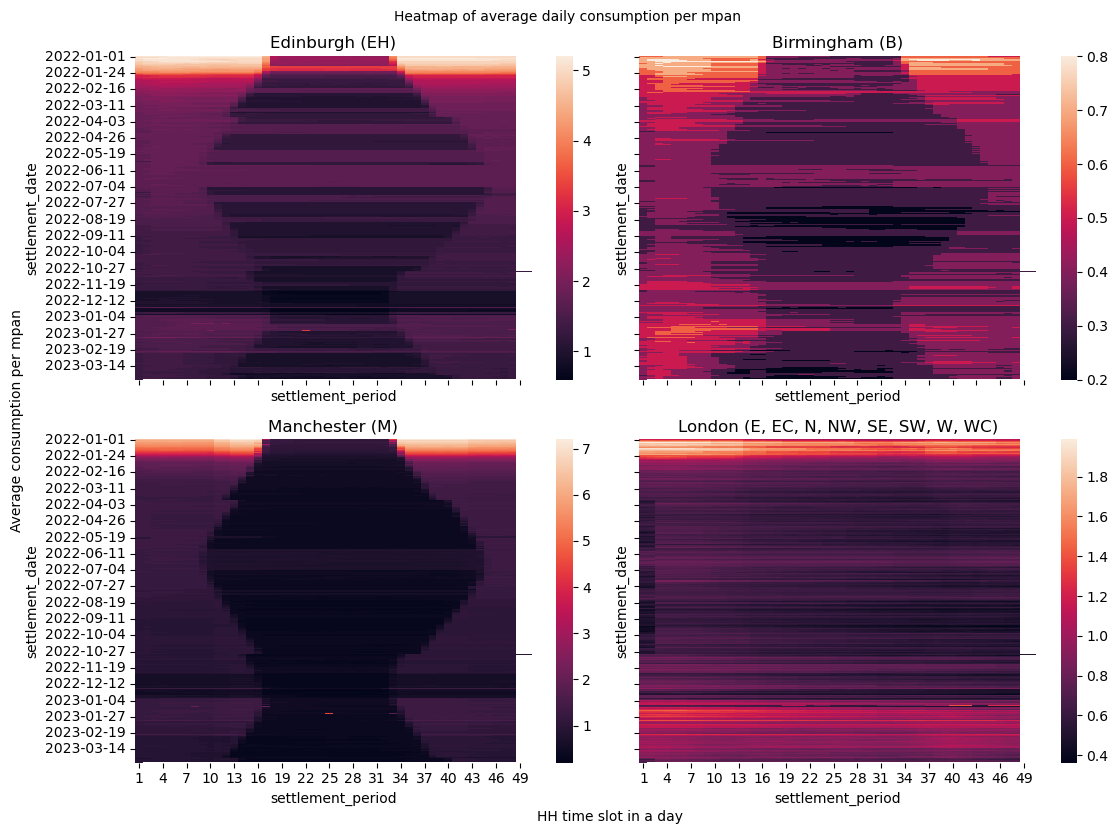

In [25]:
plot_heatmap(dft)

# PCA analysis - unsupervised machine learning (optional)

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [43]:
# can take a while with progress track
dates = dft.loc[(dft['settlement_date']>=pd.Timestamp('2022-01-01')), 'settlement_date'].dt.date.unique()
def pca_sample_list(dft_list, pc, dates):
    sample_list=[]
    for m in range(len(dates)):
        print('sample data formation progress: {:.3f}%   '.format(100*m/len(dates)), end='\r')
        instance_list=[]
        for c in range(len(pc)):
            instance = dft_list[c].loc[dft_list[c]['settlement_date'].dt.date==dates[m], 'avg_vol_per_mpan']
            if len(instance) == 48:
                instance_list.append(instance)
            else:
                pass
        if instance_list:
            sample_list.append(np.vstack(instance_list))
        else:
            pass
    print('sample matrix formation progress: 100.000%', end='\r')
    if sample_list:
        pass
    else:
        raise ValueError('need a non-empty list to return, use a larger range of dates to run this function')
    return sample_list 

In [44]:
sample_list = pca_sample_list(dft_list, pc, dates)

In [45]:
def reduce_dim(sample_list, nComp):
    pca = PCA(n_components=nComp)
    X_r_list = []
    pca_list = []
    for m in range(len(sample_list)):
        X = StandardScaler().fit_transform(sample_list[m])
        X_r = pca.fit_transform(X)
        print("explained variance ratio of each component for profile {} in the list: ".format(m), pca.explained_variance_ratio_)
        X_r_list.append(X_r)
        pca_list.append(pca)
    return X_r_list, pca_list

In [47]:
X_r_list, pca_list = reduce_dim(sample_list, 2)

explained variance ratio of each component for profile 0 in the list:  [0.86483774 0.12757291]
explained variance ratio of each component for profile 1 in the list:  [0.82272469 0.15262144]
explained variance ratio of each component for profile 2 in the list:  [0.82298136 0.15332799]
explained variance ratio of each component for profile 3 in the list:  [0.87177347 0.12037568]
explained variance ratio of each component for profile 4 in the list:  [0.87767332 0.11453636]
explained variance ratio of each component for profile 5 in the list:  [0.87639977 0.1165164 ]
explained variance ratio of each component for profile 6 in the list:  [0.84125386 0.13583748]
explained variance ratio of each component for profile 7 in the list:  [0.83878405 0.14049751]
explained variance ratio of each component for profile 8 in the list:  [0.83145174 0.14548489]
explained variance ratio of each component for profile 9 in the list:  [0.82978579 0.14528153]
explained variance ratio of each component for pro

In [48]:
def reconstruct_dim(X_r_list, pca_list):
    sample_list_rec = []
    for m in range(len(X_r_list)):
        nComp = pca_list[m].n_components
        sample_list_rec.append(np.dot(X_r_list[m], pca_list[m].components_[:nComp,:]))
    return sample_list_rec

In [49]:
sample_list_rec = reconstruct_dim(X_r_list, pca_list)

In [50]:
def reconstruct_data(dft_list, pc, dates, sample_list_rec):
    for m in range(len(dates)):
        print('reconstruct data formation progress: {:.3f}%   '.format(100*m/len(dates)), end='\r')
        for c in range(len(pc)):
            instance = dft_list[c].loc[dft_list[c]['settlement_date'].dt.date==dates[m], 'avg_vol_per_mpan']
            if (len(instance) == 48) and (instance is True):
                dft_list[c].loc[dft_list[c]['settlement_date'].dt.date==dates[m], 'avg_vol_per_mpan'] = sample_list_rec[m][c,:]
            else:
                pass  
    print('reconstruct matrix formation progress: 100.000%', end='\r')
    return dft_list 

In [51]:
dft_list_rec = reconstruct_data(dft_list, pc, dates, sample_list_rec)

In [60]:
dft_rec = pd.DataFrame(np.vstack(dft_list_rec))
dft_rec.columns = dft.columns

In [62]:
with open('reconstructable data.pickle', 'wb') as f:
            pickle.dump(sample_list, f)
        
with open('reconstructed data.pickle', 'wb') as f:
            pickle.dump(dft_rec, f)     

In [27]:
with open('reconstructable data.pickle', 'rb') as f:
    sample_list=pickle.load(f)
    
with open('reconstructed data.pickle', 'rb') as f:
    dft_rec=pickle.load(f)    